In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import optuna

import pandas as pd
import matplotlib.pyplot as plt


#load the preprocessed data
X_train = pd.read_csv("X_train_bin.csv")
X_test = pd.read_csv("X_test_bin.csv")
y_train = pd.read_csv("y_train_bin.csv").squeeze()
y_test = pd.read_csv("y_test_bin.csv").squeeze()

In [2]:
#dataframes to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [3]:
#Load the data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [4]:
#train and test sets loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [5]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

In [6]:
# Optuna study
study = optuna.create_study(direction='minimize')
num_epochs = 10

def objective(trial):

    #define hyperparameters
    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_sizes = [trial.suggest_int(f'units_l{i}', 10, 128) for i in range(n_layers)]
    dropout = trial.suggest_float('dropout', 0.2, 0.7)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048, 3000, 4096, 5000, 7500, 8192])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Build model
    layers = []
    in_features = X_train_tensor.shape[1]
    for units in hidden_sizes:
        layers.append(nn.Linear(in_features, units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        in_features = units
    layers.append(nn.Linear(in_features, 1))
    model = nn.Sequential(*layers).to(device)

    # Optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    #dataloaders with batch size based on optuna suggestion
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    #training phase
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            loss.backward()
            optimizer.step()

    #validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)
            val_loss += loss_fn(outputs, yb).item() * xb.size(0)
    val_loss /= len(test_loader.dataset)
    return val_loss

# Run Optuna optimization
study.optimize(objective, n_trials=50)

[I 2025-05-29 15:10:09,348] A new study created in memory with name: no-name-221a15e8-91ec-42d3-a6a8-2f379af0813f
[I 2025-05-29 15:11:53,523] Trial 0 finished with value: 0.5407605414621788 and parameters: {'n_layers': 5, 'units_l0': 112, 'units_l1': 45, 'units_l2': 37, 'units_l3': 104, 'units_l4': 98, 'dropout': 0.23606610908077408, 'lr': 0.0017870584154464524, 'batch_size': 4096, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5407605414621788.
[I 2025-05-29 15:13:40,048] Trial 1 finished with value: 0.5286916960767498 and parameters: {'n_layers': 3, 'units_l0': 104, 'units_l1': 55, 'units_l2': 44, 'dropout': 0.5135043228414135, 'lr': 0.000859012422858563, 'batch_size': 1024, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.5286916960767498.
[I 2025-05-29 15:15:17,325] Trial 2 finished with value: 0.013570461956892101 and parameters: {'n_layers': 5, 'units_l0': 73, 'units_l1': 61, 'units_l2': 123, 'units_l3': 66, 'units_l4': 57, 'dropout': 0.6784926314526227, 'lr': 0.00546863541

In [7]:
# Print best result
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value:  0.001933293953400736
  Params: 
    n_layers: 4
    units_l0: 107
    units_l1: 20
    units_l2: 109
    units_l3: 60
    dropout: 0.2725519019624006
    lr: 0.0002363411909183287
    batch_size: 256
    optimizer: Adam


In [14]:
input_dim = X_train_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
#build the model from trial.params
layers = []
in_features = input_dim

for i in range(trial.params["n_layers"]):
    out_features = trial.params[f"units_l{i}"]
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(trial.params["dropout"]))
    in_features = out_features

layers.append(nn.Linear(in_features, 1))  # Output layer
model_test = nn.Sequential(*layers).to(device)

In [21]:
#create the optimizer based on trial.params
if trial.params["optimizer"] == "Adam":
    optimizer = optim.Adam(model_test.parameters(), lr=trial.params["lr"])
elif trial.params["optimizer"] == "SGD":
    optimizer = optim.SGD(model_test.parameters(), lr=trial.params["lr"])
elif trial.params["optimizer"] == "RMSprop":
    optimizer = optim.RMSprop(model_test.parameters(), lr=trial.params["lr"])
else:
    raise ValueError(f"Unsupported optimizer: {trial.params['optimizer']}")

In [22]:
#create the dataloaders with the batch size from trial.params
train_loader = DataLoader(train_dataset, batch_size=trial.params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=trial.params["batch_size"], shuffle=False)

In [23]:
criterion = nn.BCEWithLogitsLoss()
epochs = 50

#set up lists to store losses and recalls
train_losses = []
val_losses = []
train_recalls = []
val_recalls = []

#start training
for epoch in range(epochs):

    #training phase
    model_test.train()

    running_train_loss = 0.0
    train_preds = []
    train_targets = []

    #load the data in batches
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model_test(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).int()
        train_preds.extend(preds.cpu().numpy().flatten())
        train_targets.extend(y_batch.cpu().numpy().flatten())

    # Calculate average loss and recall for training
    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_recall = recall_score(train_targets, train_preds)
    train_losses.append(avg_train_loss)
    train_recalls.append(train_recall)

    #validation phase
    model_test.eval()
    running_val_loss = 0.0
    val_preds = []
    val_targets = []

    #load the validation data in batches
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float().view(-1, 1)

            outputs = model_test(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).int()
            val_preds.extend(preds.cpu().numpy().flatten())
            val_targets.extend(y_batch.cpu().numpy().flatten())

    avg_val_loss = running_val_loss / len(test_loader.dataset)
    val_recall = recall_score(val_targets, val_preds)
    val_losses.append(avg_val_loss)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {avg_train_loss} - Val Loss: {avg_val_loss} - "
          f"Train Recall: {train_recall} - Val Recall: {val_recall}")


Epoch 1/50 - Train Loss: 0.06888514082972012 - Val Loss: 0.007028711837144819 - Train Recall: 0.9065722990746172 - Val Recall: 0.9986374861619688
Epoch 2/50 - Train Loss: 0.008316445534926725 - Val Loss: 0.0043657098254890345 - Train Recall: 0.9975777302575554 - Val Recall: 0.9990632717363536
Epoch 3/50 - Train Loss: 0.005836193454632576 - Val Loss: 0.005508913858244092 - Train Recall: 0.9978568589974074 - Val Recall: 0.9864174401771268
Epoch 4/50 - Train Loss: 0.004825318272415477 - Val Loss: 0.0029019458764694265 - Train Recall: 0.9980035198607194 - Val Recall: 0.9992619716710665
Epoch 5/50 - Train Loss: 0.004460684452255811 - Val Loss: 0.002346042283137348 - Train Recall: 0.9980792157901709 - Val Recall: 0.9992903573760255
Epoch 6/50 - Train Loss: 0.004031762594919268 - Val Loss: 0.0021493971536105452 - Train Recall: 0.9982306076490737 - Val Recall: 0.9992619716710665
Epoch 7/50 - Train Loss: 0.003655843586371803 - Val Loss: 0.0025565772251178774 - Train Recall: 0.9982211456578922 -

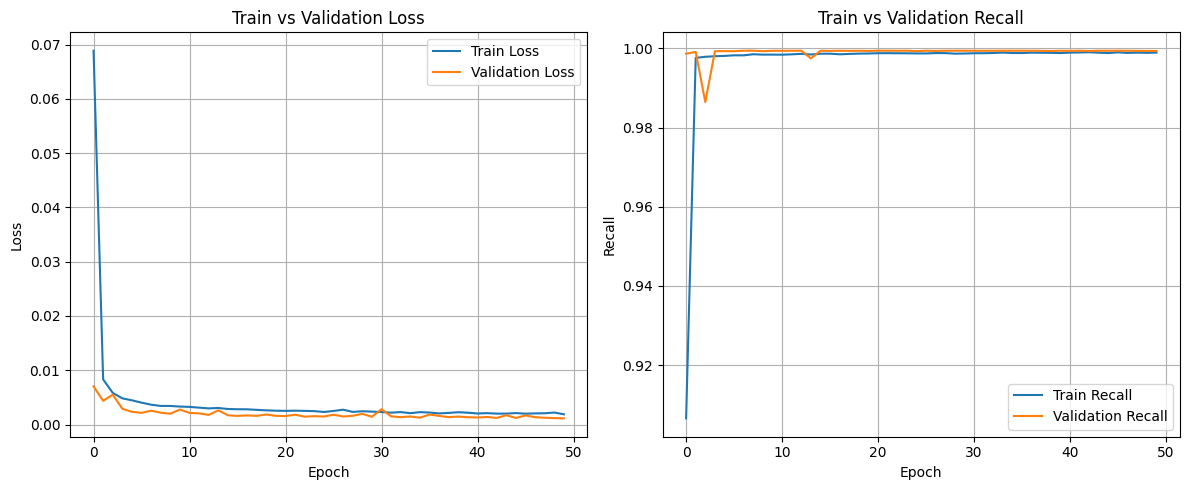

In [24]:
#display the final plots for losses and recalls
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot recall
plt.subplot(1, 2, 2)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Train vs Validation Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()